In [70]:
%matplotlib widget
import time

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

from scipy import constants
import os
import csv
import logging
from pyrfu import mms, pyrf, plot
# from pyrfu.plot import plot_line, plot_spectr, use_pyrfu_style
mms.db_init(default="local", local="../../../data/mms")
plt.style.use('figstyle.mplstyle')
logging.getLogger('matplotlib.font_manager').disabled = True

[18-Mar-25 09:23:00] INFO: Updating MMS data access configuration in /homelocal/atlass/.venv/lib/python3.12/site-packages/pyrfu/mms/config.json...
[18-Mar-25 09:23:00] INFO: Updating MMS SDC credentials in /homelocal/atlass/.config/python_keyring...


In [30]:
def write_to_file(filepath, output):
    # Ensure file exists and write header if not present
    if not os.path.exists(filepath):
        output_header = ['X', 'Y', 'Z', 'start', 'end']
        with open(filepath, "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerow(output_header)

    # Write results to file
    with open(filepath, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(output)

In [31]:
# read SW tints for specified spacecraft
ic = 1
sw_tints = np.genfromtxt(f'sw_tints/mms{ic}_sw_tints.txt', dtype=np.str_).tolist()
print(len(sw_tints))

3431


In [32]:
# r_xyz = [mms.get_data('r_gse_mec_srvy_l2', tint, ic) for ic in range(1,5)]
# Let 'R' denote tints, and 'r' individual ones 
def write_avgpos():
    ntints = len(sw_tints) 
    nsel = 200
    datastep = int(ntints / nsel)
    tints = sw_tints[::3]
    ntints_sel = len(tints)
    mean_R_xyz = []
    dt = np.timedelta64(1, '[h]')
    for i, tint in enumerate(tints):
        print(f"Time interval {i+1}/{ntints_sel}")
        r_xyz = mms.get_data('r_gse_mec_srvy_l2', tint, ic)
        s, e = np.datetime64(tint[0]), np.datetime64(tint[-1])
        left = s
        while left < e:
            right = left + dt
            if right > e:
                right = e
            tint_clip = [str(left), str(right)]
            # print(f'\t{tint_clip}')
            r_clipped = pyrf.time_clip(r_xyz, tint_clip)
            r_clipped_avg = np.mean(r_clipped.data, axis=0)
            X, Y, Z = r_clipped_avg
            write_to_file(f"mms{ic}_1h_avgR.csv", [X, Y, Z, tint_clip[0], tint_clip[-1]])
            mean_R_xyz.append(r_clipped_avg.data.tolist()+ tint_clip)
            left += dt

In [33]:
# np.savetxt(f"mms{ic}_10min_avgR.csv", mean_R_xyz, fmt='%s')

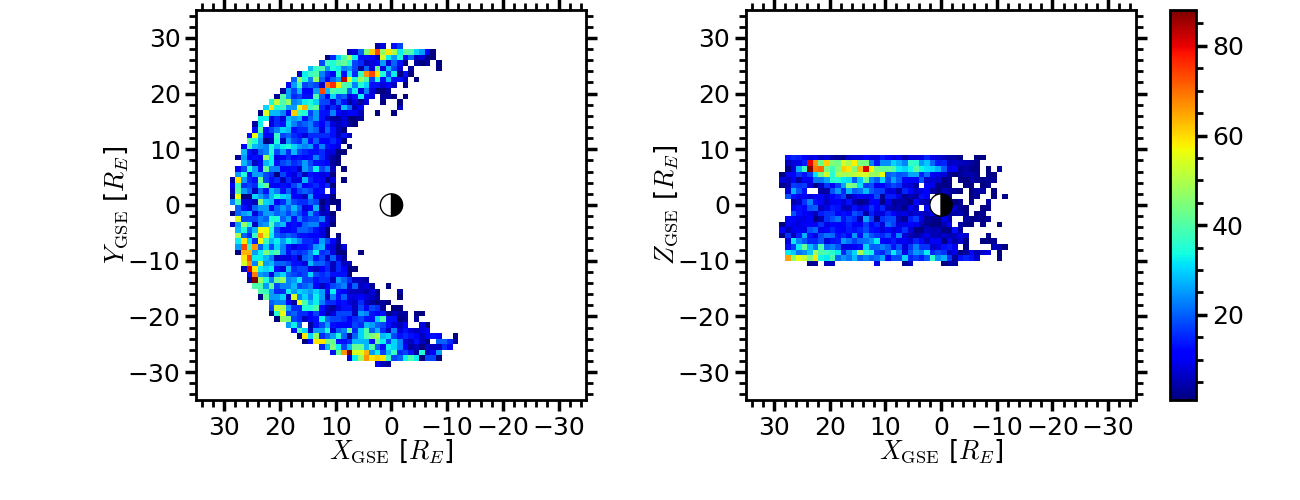

In [95]:
# figure to plot avg positions of specified sc
def _add_earth(ax=None, **kwargs):
    # Made by Louis
    theta1, theta2 = 90.0, 270.0
    nightside_ = Wedge((0.0, 0.0), 2.0, theta1, theta2, fc="k", ec="k", **kwargs)
    dayside_ = Wedge((0.0, 0.0), 2.0, theta2, theta1, fc="w", ec="k", **kwargs)
    for wedge in [nightside_, dayside_]:
        ax.add_artist(wedge)
    return [nightside_, dayside_]



def _read_scdist(filename):
    scdist_data = np.genfromtxt(filename, names=True,dtype=None,delimiter=',',skip_header=1)
    data_dict = {name: scdist_data[name] for name in scdist_data.dtype.names}
    X, Y, Z, start, end = data_dict.values()
    X /= 6371
    Y /= 6371
    Z /= 6371
    every = 1
    return X[::every], Y[::every], Z[::every], start[::every]

X, Y, Z, T = _read_scdist(f'_mms{ic}_1h_avgR.csv')

# T_ = pyrf.datetime642ttns(pyrf.iso86012unix(T))
T_ = pyrf.iso86012unix(T)

# initialize figure
# fig = plt.figure(figsize=(8, 4))
fig, axs = plt.subplots(ncols=2, figsize=(13, 5))
plt.subplots_adjust(hspace=0.2, top=0.98, bottom=0.2)
x_mp, y_mp = pyrf.magnetosphere("mp_shue1998") # Magnetosphere
fs = 19 # Fontsize
ylim = 30
xlim = 25
zlim = 10
# top view
bins = 70
maxval = 35
# axs[0].scatter(X, Y,s=1, c=T_, clim=[T_[0], T_[-1]], cmap='jet',zorder=6)
axs[0].set_xlim(-maxval, maxval)
axs[0].set_ylim(-maxval, maxval)

axs[0].hist2d(X, Y, range=[[-maxval, maxval], [-maxval, maxval]], bins=[bins, bins],cmin=1, cmap='jet')

axs[0].set_xlabel(r"$X_\mathrm{GSE}$ [$R_E$]", fontsize=fs)
axs[0].set_ylabel(r"$Y_\mathrm{GSE}$ [$R_E$]", fontsize=fs)


# side view
# axs[1].scatter(X, Z, s=1, c=T_, clim=[T_[0], T_[-1]], cmap='jet',zorder=6)
axs[1].set_xlim(-maxval, maxval)
axs[1].set_ylim(-maxval, maxval)
axs[1].hist2d(X, Z, range=[[-maxval, maxval], [-maxval, maxval]], bins=[bins, bins],cmin=1, cmap='jet')


axs[1].set_xlabel(r"$X_\mathrm{GSE}$ [$R_E$]", fontsize=fs)
axs[1].set_ylabel(r"$Z_\mathrm{GSE}$ [$R_E$]", fontsize=fs)

cax = fig.add_axes([0.9, 0.2, 0.02, 0.78])
fig.colorbar(axs[1].collections[0], cax=cax)
cax.grid(False)

for ax in axs:
    ax.invert_xaxis()
    ax.set_aspect(1)
    ax.grid(False)
    _add_earth(ax)
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(2))  # Minor ticks every 0.5 units
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))  # Minor ticks every 0.5 units
    

first_tint = sw_tints[0][0][:10]
last_tint = sw_tints[-1][0][:10]
fig.savefig('plots/kiruna/spatial-dist.png', dpi=300)